# Test technique
## Problème de classification : 
Prédire la variable $TARGET\_FLAG$ qui correspond à si un client a été impliqué dans un accident ou pas

### Importation des librairies

In [442]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import sklearn
import seaborn as sns
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, balanced_accuracy_score,  plot_roc_curve, make_scorer, roc_curve

### Chargement des données
Nous allons construire notre modèle et l'évaluer grâce au document "training" et prédire les modalités du document "test"

In [443]:
training_data = pd.read_csv("train_auto.csv") 
test_data = pd.read_csv("test_auto.csv")

### Exploration de données
$INDEX$ = variable d'identification

$TARGET\_FLAG$ = si le client a été impliqué dans un accident

$TARGET\_AMT$ = si impliqué dans un accident -> cout de l'accident

$AGE$ = age du conducteur

$BLUEBOOK$ = valeur du véhicule

$CAR\_AGE$ = age du véhicule

$CAR\_TYPE$ = type de véhicule

$CAR\_USE$ = usage du véhicule

$CLM\_FREQ$ = nombre de réclamations faites par le client (5 dernières années)

$EDUCATION$ = niveau d'éducation max

$HOMEKIDS$ = nombre d'enfants

$HOME_VAL$ = valeur de la maison si propriétaire

$INCOME$ = salaire

$JOB$ = catégorie de travail

$KIDSDRIV$ = nombre d'enfants qui conduisent

$MSTATUS$ = statut marital

$MVR_PTS$= points sur le permis de conduire

$OLDCLAIM$ = coût total des dernières réclamations faites par le client (5 dernières années)

$PARENT1$ = si le client est en relation monoparentale 

$RED\_CAR$ = si le vehicule est rouge

$REVOKED$ = si le permis a été annulé durant les 7 dernières années 

$SEX$ = $Sexe du client$

$TIF$ = $Time in Force$

$TRAVTIME$ = distance du client par rapport à son travail

$URBANICITY$ = type de région où le client vit / travaille

$YOJ$ = nombre d'années du client au travail

Visualisation des 5 premières lignes pour avoir une idée des données

In [444]:
training_data.head()

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,1,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,...,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
1,2,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",...,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
2,4,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",...,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
3,5,0,0.0,0,51.0,0,14.0,NaN,No,"$306,251",...,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
4,6,0,0.0,0,50.0,0,NaN,"$114,986",No,"$243,925",...,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


Dimensions du dataset

In [445]:
print(training_data.shape)

(8161, 26)


Noms des colonnes précédemment explicitées

In [446]:
print(training_data.columns)

Index(['INDEX', 'TARGET_FLAG', 'TARGET_AMT', 'KIDSDRIV', 'AGE', 'HOMEKIDS',
       'YOJ', 'INCOME', 'PARENT1', 'HOME_VAL', 'MSTATUS', 'SEX', 'EDUCATION',
       'JOB', 'TRAVTIME', 'CAR_USE', 'BLUEBOOK', 'TIF', 'CAR_TYPE', 'RED_CAR',
       'OLDCLAIM', 'CLM_FREQ', 'REVOKED', 'MVR_PTS', 'CAR_AGE', 'URBANICITY'],
      dtype='object')


Type de chaque variable

In [447]:
print(training_data.dtypes)

INDEX            int64
TARGET_FLAG      int64
TARGET_AMT     float64
KIDSDRIV         int64
AGE            float64
HOMEKIDS         int64
YOJ            float64
INCOME          object
PARENT1         object
HOME_VAL        object
MSTATUS         object
SEX             object
EDUCATION       object
JOB             object
TRAVTIME         int64
CAR_USE         object
BLUEBOOK        object
TIF              int64
CAR_TYPE        object
RED_CAR         object
OLDCLAIM        object
CLM_FREQ         int64
REVOKED         object
MVR_PTS          int64
CAR_AGE        float64
URBANICITY      object
dtype: object


Nombre de valeurs pour chaque variable

In [448]:
print(training_data.count())

INDEX          8161
TARGET_FLAG    8161
TARGET_AMT     8161
KIDSDRIV       8161
AGE            8155
HOMEKIDS       8161
YOJ            7707
INCOME         7716
PARENT1        8161
HOME_VAL       7697
MSTATUS        8161
SEX            8161
EDUCATION      8161
JOB            7635
TRAVTIME       8161
CAR_USE        8161
BLUEBOOK       8161
TIF            8161
CAR_TYPE       8161
RED_CAR        8161
OLDCLAIM       8161
CLM_FREQ       8161
REVOKED        8161
MVR_PTS        8161
CAR_AGE        7651
URBANICITY     8161
dtype: int64


Stats descriptives pour chaque variable

In [449]:
training_data.describe(include = 'all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
INDEX,8161,NaN,NaN,NaN,5151.87,2978.89,1,2559,5133,7745,10302
TARGET_FLAG,8161,NaN,NaN,NaN,0.263816,0.440728,0,0,0,1,1
TARGET_AMT,8161,NaN,NaN,NaN,1504.32,4704.03,0,0,0,1036,107586
KIDSDRIV,8161,NaN,NaN,NaN,0.171057,0.511534,0,0,0,0,4
AGE,8155,NaN,NaN,NaN,44.7903,8.62759,16,39,45,51,81
HOMEKIDS,8161,NaN,NaN,NaN,0.721235,1.11632,0,0,0,1,5
YOJ,7707,NaN,NaN,NaN,10.4993,4.09247,0,9,11,13,23
INCOME,7716,6612,$0,615,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PARENT1,8161,2,No,7084,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HOME_VAL,7697,5106,$0,2294,NaN,NaN,NaN,NaN,NaN,NaN,NaN


On supprime la variable $INDEX$ qui ne contient que des valeurs uniques et qui ne sert à rien dans l'étude

In [452]:
training_data = training_data.drop(['INDEX'], axis = 1)
test_data = test_data.drop(['INDEX'], axis = 1)

### Traitement des valeurs manquantes
Nombre et pourcentage

In [450]:
print(training_data.isnull().sum())
print(test_data.isnull().sum())

INDEX            0
TARGET_FLAG      0
TARGET_AMT       0
KIDSDRIV         0
AGE              6
HOMEKIDS         0
YOJ            454
INCOME         445
PARENT1          0
HOME_VAL       464
MSTATUS          0
SEX              0
EDUCATION        0
JOB            526
TRAVTIME         0
CAR_USE          0
BLUEBOOK         0
TIF              0
CAR_TYPE         0
RED_CAR          0
OLDCLAIM         0
CLM_FREQ         0
REVOKED          0
MVR_PTS          0
CAR_AGE        510
URBANICITY       0
dtype: int64
INDEX             0
TARGET_FLAG    2141
TARGET_AMT     2141
KIDSDRIV          0
AGE               1
HOMEKIDS          0
YOJ              94
INCOME          125
PARENT1           0
HOME_VAL        111
MSTATUS           0
SEX               0
EDUCATION         0
JOB             139
TRAVTIME          0
CAR_USE           0
BLUEBOOK          0
TIF               0
CAR_TYPE          0
RED_CAR           0
OLDCLAIM          0
CLM_FREQ          0
REVOKED           0
MVR_PTS           0
CAR_AGE      

In [451]:
print(training_data.isnull().sum()/training_data.shape[0]*100)
print(test_data.isnull().sum()/test_data.shape[0]*100)

INDEX          0.000000
TARGET_FLAG    0.000000
TARGET_AMT     0.000000
KIDSDRIV       0.000000
AGE            0.073520
HOMEKIDS       0.000000
YOJ            5.563044
INCOME         5.452763
PARENT1        0.000000
HOME_VAL       5.685578
MSTATUS        0.000000
SEX            0.000000
EDUCATION      0.000000
JOB            6.445289
TRAVTIME       0.000000
CAR_USE        0.000000
BLUEBOOK       0.000000
TIF            0.000000
CAR_TYPE       0.000000
RED_CAR        0.000000
OLDCLAIM       0.000000
CLM_FREQ       0.000000
REVOKED        0.000000
MVR_PTS        0.000000
CAR_AGE        6.249234
URBANICITY     0.000000
dtype: float64
INDEX            0.000000
TARGET_FLAG    100.000000
TARGET_AMT     100.000000
KIDSDRIV         0.000000
AGE              0.046707
HOMEKIDS         0.000000
YOJ              4.390472
INCOME           5.838393
PARENT1          0.000000
HOME_VAL         5.184493
MSTATUS          0.000000
SEX              0.000000
EDUCATION        0.000000
JOB              6.4922

Etant donné qu'il n'y a que 0.07% de valeurs manquantes concernant les âges des conducteurs, on peut directement supprimer les observations possédant des valeurs manquantes

In [453]:
training_data = training_data[training_data['AGE'].notnull()]
test_data = test_data[test_data['AGE'].notnull()]
training_data['AGE'] = training_data['AGE'].astype(int)
test_data['AGE'] = test_data['AGE'].astype(int)

Pour toutes les variables étant des prix, on supprime les caractères de type , et $ et on convertit les valeurs en float

In [454]:
training_data['INCOME'] = training_data['INCOME'].replace('[$,]', '', regex=True).astype(float)
training_data['HOME_VAL'] = training_data['HOME_VAL'].replace('[$,]', '', regex=True).astype(float)
training_data['BLUEBOOK'] = training_data['BLUEBOOK'].replace('[$,]', '', regex=True).astype(float)
training_data['OLDCLAIM'] = training_data['OLDCLAIM'].replace('[$,]', '', regex=True).astype(float)

test_data['INCOME'] = test_data['INCOME'].replace('[$,]', '', regex=True).astype(float)
test_data['HOME_VAL'] = test_data['HOME_VAL'].replace('[$,]', '', regex=True).astype(float)
test_data['BLUEBOOK'] = test_data['BLUEBOOK'].replace('[$,]', '', regex=True).astype(float)
test_data['OLDCLAIM'] = test_data['OLDCLAIM'].replace('[$,]', '', regex=True).astype(float)

Presque 7% des $JOB$ sont manquants. Pour compléter ces valeurs, on part du postulat que l'$EDUCATION$ a un impact sur le $JOB$ donc pour les $JOB$s manquants, on remplace la valeur manquante par le $JOB$ le plus probable avec un tel niveau d'étude en calculant grâce à notre fonction impute_jobs le job le plus fréquent

In [455]:
training_data.loc[(training_data.EDUCATION == 'PhD') & (training_data.JOB.isna()), "JOB"] = impute_jobs("PhD")
training_data.loc[(training_data.EDUCATION == 'Masters') & (training_data.JOB.isna()), "JOB"] = impute_jobs("Masters")
training_data.loc[(training_data.EDUCATION == 'Bachelors') & (training_data.JOB.isna()), "JOB"] = impute_jobs("Bachelors")
training_data.loc[(training_data.EDUCATION == 'z_High School') & (training_data.JOB.isna()), "JOB"] = impute_jobs("z_High School")
training_data.loc[(training_data.EDUCATION == '<High School') & (training_data.JOB.isna()), "JOB"] = impute_jobs("<High School")

test_data.loc[(test_data.EDUCATION == 'PhD') & (test_data.JOB.isna()), "JOB"] = impute_jobs("PhD")
test_data.loc[(test_data.EDUCATION == 'Masters') & (test_data.JOB.isna()), "JOB"] = impute_jobs("Masters")
test_data.loc[(test_data.EDUCATION == 'Bachelors') & (test_data.JOB.isna()), "JOB"] = impute_jobs("Bachelors")
test_data.loc[(test_data.EDUCATION == 'z_High School') & (test_data.JOB.isna()), "JOB"] = impute_jobs("z_High School")
test_data.loc[(test_data.EDUCATION == '<High School') & (test_data.JOB.isna()), "JOB"] = impute_jobs("<High School")

Pour les variables numériques manquantes, on remplace les valeurs manquantes par la moyenne de chacune de ces variables

In [456]:
training_data['INCOME'].fillna((training_data['INCOME'].mean()), inplace=True)
training_data['YOJ'].fillna((training_data['YOJ'].mean()), inplace=True)
training_data['HOME_VAL'].fillna((training_data['HOME_VAL'].mean()), inplace=True)
training_data['CAR_AGE'].fillna((training_data['CAR_AGE'].mean()), inplace=True)


test_data['INCOME'].fillna((test_data['INCOME'].mean()), inplace=True)
test_data['YOJ'].fillna((test_data['YOJ'].mean()), inplace=True)
test_data['HOME_VAL'].fillna((test_data['HOME_VAL'].mean()), inplace=True)
test_data['CAR_AGE'].fillna((test_data['CAR_AGE'].mean()), inplace=True)

### Etude des variables pour la construction de notre modèle
On définit nos variables numériques, nos variables catégoriques et notre variable cible.

In [458]:
num_var = ['KIDSDRIV', 'AGE', 'HOMEKIDS',
          'TRAVTIME','TIF', "BLUEBOOK","OLDCLAIM",
          'CLM_FREQ','MVR_PTS', "INCOME","YOJ","HOME_VAL",
          "CAR_AGE"]

cat_var = ['PARENT1', 'MSTATUS', 'SEX', 'EDUCATION',
          'CAR_USE','CAR_TYPE','RED_CAR','REVOKED',
          'URBANICITY',"JOB"]

target = ['TARGET_FLAG']

On supprime la variable $TARGET\_AMT$ inutile à l'étude et on vérifie qu'il n'y pas plus de valeurs manquantes

In [459]:
Col_to_drop = ["TARGET_AMT"]
training_data =training_data.drop(Col_to_drop, axis=1)
test_data =test_data.drop(Col_to_drop, axis=1)
print(training_data.columns)

Index(['TARGET_FLAG', 'KIDSDRIV', 'AGE', 'HOMEKIDS', 'YOJ', 'INCOME',
       'PARENT1', 'HOME_VAL', 'MSTATUS', 'SEX', 'EDUCATION', 'JOB', 'TRAVTIME',
       'CAR_USE', 'BLUEBOOK', 'TIF', 'CAR_TYPE', 'RED_CAR', 'OLDCLAIM',
       'CLM_FREQ', 'REVOKED', 'MVR_PTS', 'CAR_AGE', 'URBANICITY'],
      dtype='object')


In [460]:
print(training_data.isnull().sum()/training_data.shape[0]*100)
print(test_data.isnull().sum()/test_data.shape[0]*100)

TARGET_FLAG    0.0
KIDSDRIV       0.0
AGE            0.0
HOMEKIDS       0.0
YOJ            0.0
INCOME         0.0
PARENT1        0.0
HOME_VAL       0.0
MSTATUS        0.0
SEX            0.0
EDUCATION      0.0
JOB            0.0
TRAVTIME       0.0
CAR_USE        0.0
BLUEBOOK       0.0
TIF            0.0
CAR_TYPE       0.0
RED_CAR        0.0
OLDCLAIM       0.0
CLM_FREQ       0.0
REVOKED        0.0
MVR_PTS        0.0
CAR_AGE        0.0
URBANICITY     0.0
dtype: float64
TARGET_FLAG    100.0
KIDSDRIV         0.0
AGE              0.0
HOMEKIDS         0.0
YOJ              0.0
INCOME           0.0
PARENT1          0.0
HOME_VAL         0.0
MSTATUS          0.0
SEX              0.0
EDUCATION        0.0
JOB              0.0
TRAVTIME         0.0
CAR_USE          0.0
BLUEBOOK         0.0
TIF              0.0
CAR_TYPE         0.0
RED_CAR          0.0
OLDCLAIM         0.0
CLM_FREQ         0.0
REVOKED          0.0
MVR_PTS          0.0
CAR_AGE          0.0
URBANICITY       0.0
dtype: float64


On convertit nos variables catégoriques en "category"

In [461]:
for col in cat_var:
    training_data[col] = training_data[col].astype('category')
    test_data[col]  = test_data[col].astype('category')
training_data['TARGET_FLAG'] = training_data["TARGET_FLAG"].astype('category')
test_data['TARGET_FLAG'] = test_data["TARGET_FLAG"].astype('category')
training_data.dtypes
test_data.dtypes

TARGET_FLAG    category
KIDSDRIV          int64
AGE               int32
HOMEKIDS          int64
YOJ             float64
INCOME          float64
PARENT1        category
HOME_VAL        float64
MSTATUS        category
SEX            category
EDUCATION      category
JOB            category
TRAVTIME          int64
CAR_USE        category
BLUEBOOK        float64
TIF               int64
CAR_TYPE       category
RED_CAR        category
OLDCLAIM        float64
CLM_FREQ          int64
REVOKED        category
MVR_PTS           int64
CAR_AGE         float64
URBANICITY     category
dtype: object

### Analyses univariées
#### Analyse de la distribution de la variable cible 

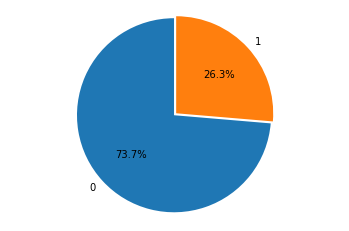

In [462]:
labels = '0', '1'
y0 = training_data.loc[training_data['TARGET_FLAG'] == 0].shape[0]
y1 = training_data.loc[training_data['TARGET_FLAG'] == 1].shape[0]
sizes = [y0,y1]
explode = (0,0.03)

fig, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')
plt.show()

#### Analyse des distributions des variables numériques dans le doc training et test

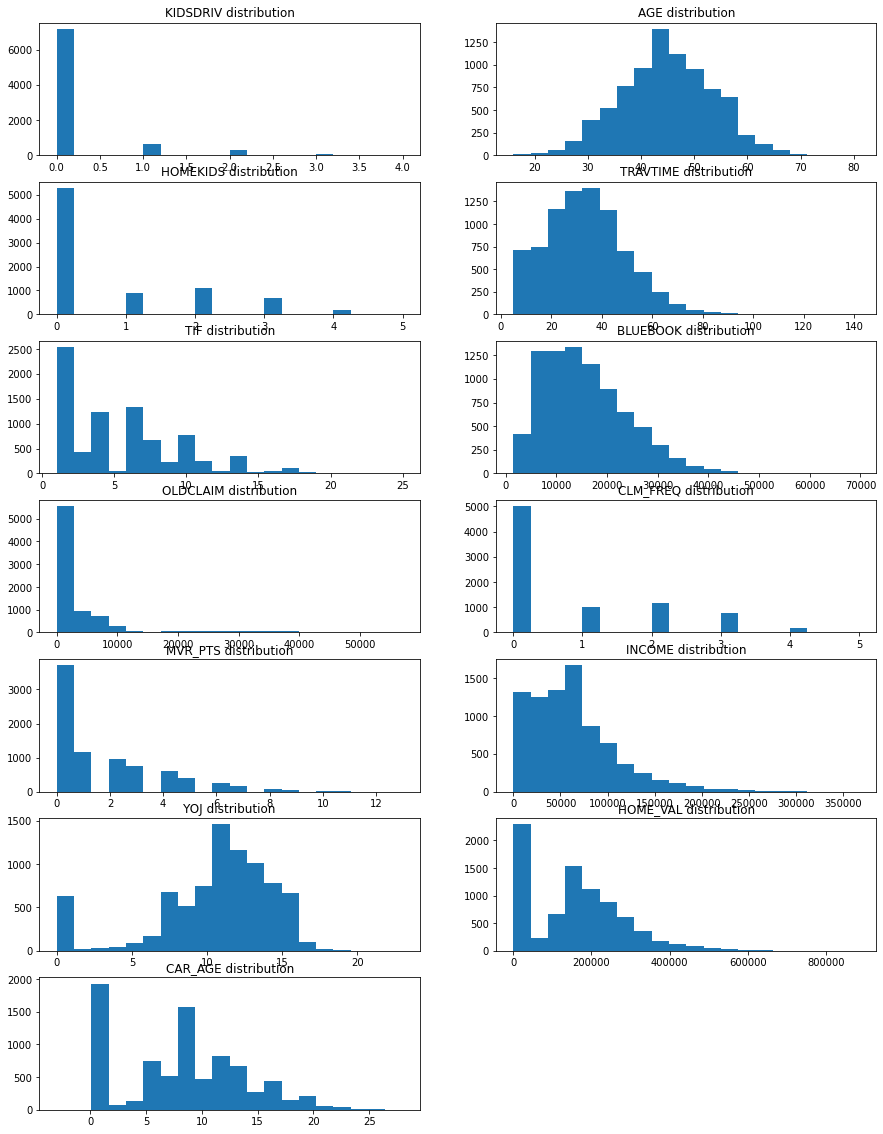

In [463]:
fig=plt.figure(figsize=(15, 20))
i=1
for feature in num_var:
    plt.subplot(7, 2, i)
    plt.hist(training_data[feature], bins = 20)
    plt.title(feature + ' distribution')
    i+=1

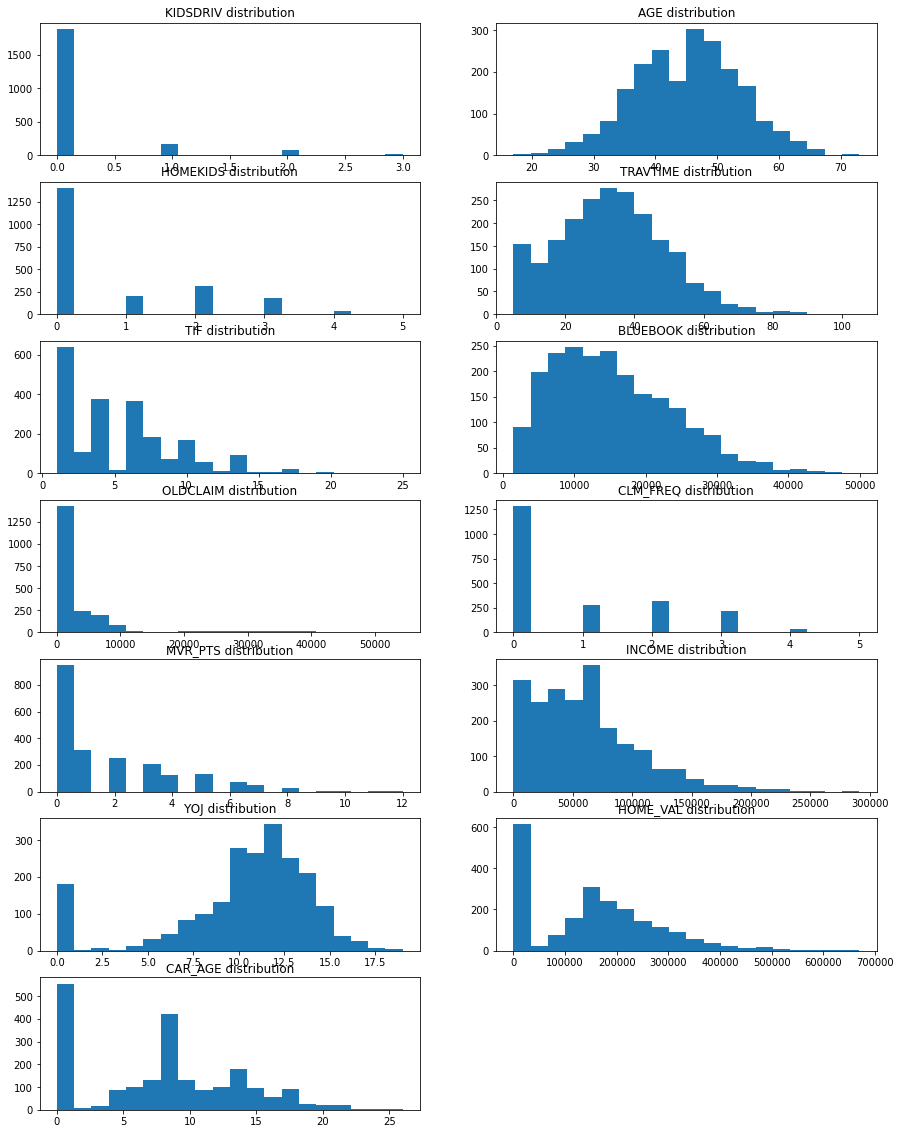

In [464]:
fig=plt.figure(figsize=(15, 20))
i=1
for feature in num_var:
    plt.subplot(7, 2, i)
    plt.hist(test_data[feature], bins = 20)
    plt.title(feature + ' distribution')
    i+=1

#### Analyse des distributions des variables catégoriques dans le doc training et test

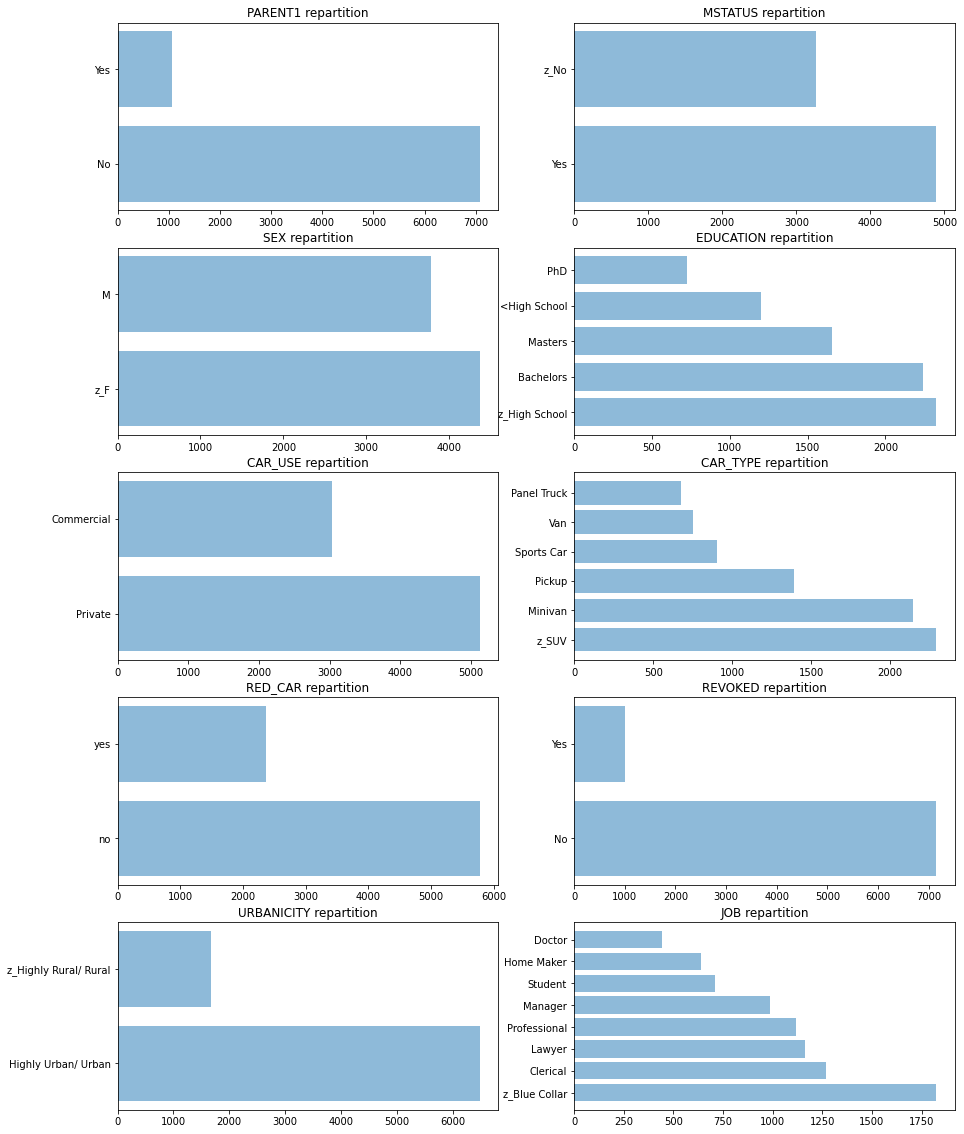

In [465]:
fig=plt.figure(figsize=(15, 20))
i=1

for feature in cat_var:
    plt.subplot(5, 2, i)
    dfTemp = pd.DataFrame(training_data[feature].value_counts()).reset_index()
    y_pos = np.arange(len(dfTemp['index']))
    plt.barh(y_pos, dfTemp[feature], align='center', alpha=0.5)
    plt.yticks(y_pos, dfTemp['index'])
    plt.title(feature + ' repartition')
    i+=1

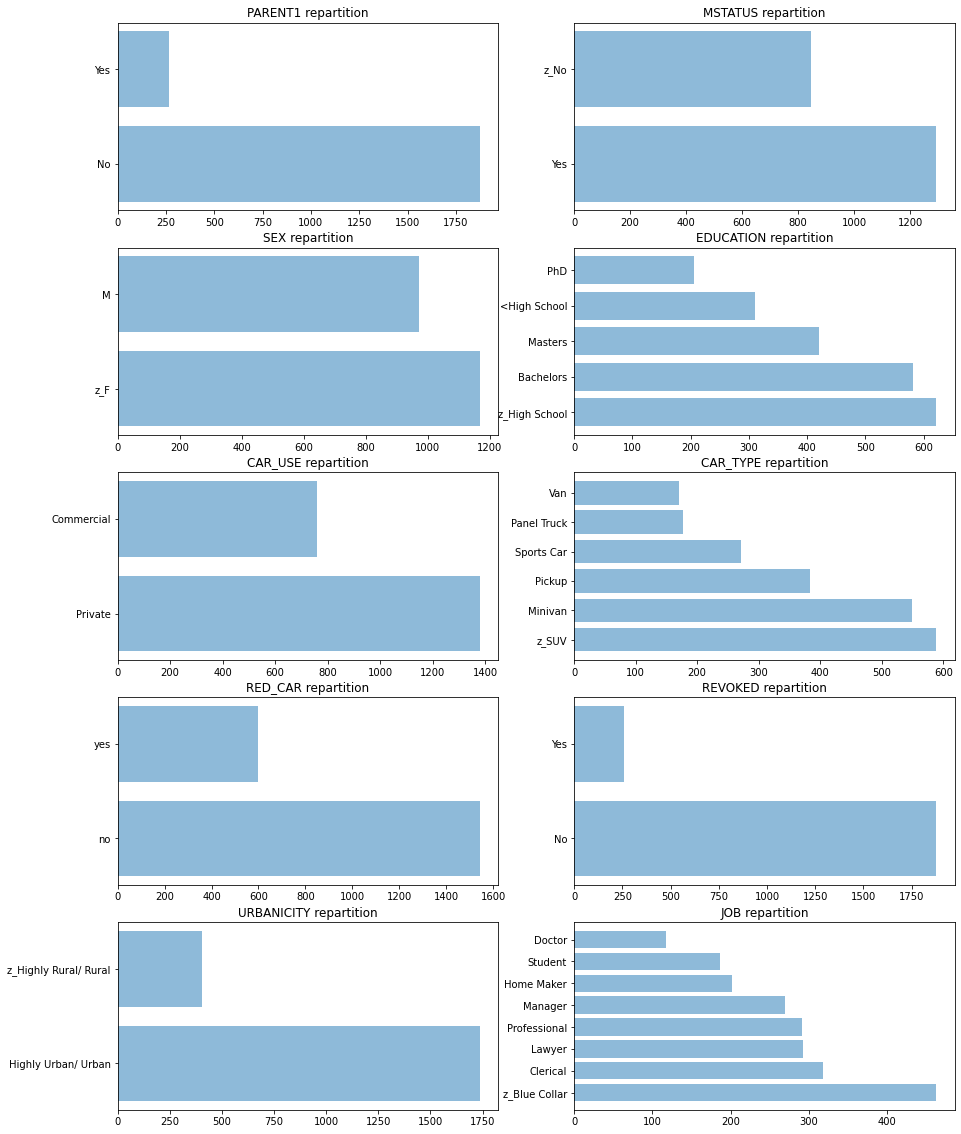

In [466]:
fig=plt.figure(figsize=(15, 20))
i=1

for feature in cat_var:
    plt.subplot(5, 2, i)
    dfTemp = pd.DataFrame(test_data[feature].value_counts()).reset_index()
    y_pos = np.arange(len(dfTemp['index']))
    plt.barh(y_pos, dfTemp[feature], align='center', alpha=0.5)
    plt.yticks(y_pos, dfTemp['index'])
    plt.title(feature + ' repartition')
    i+=1

### Analyses bivariées
#### Matrice des corrélations pour les variables numériques

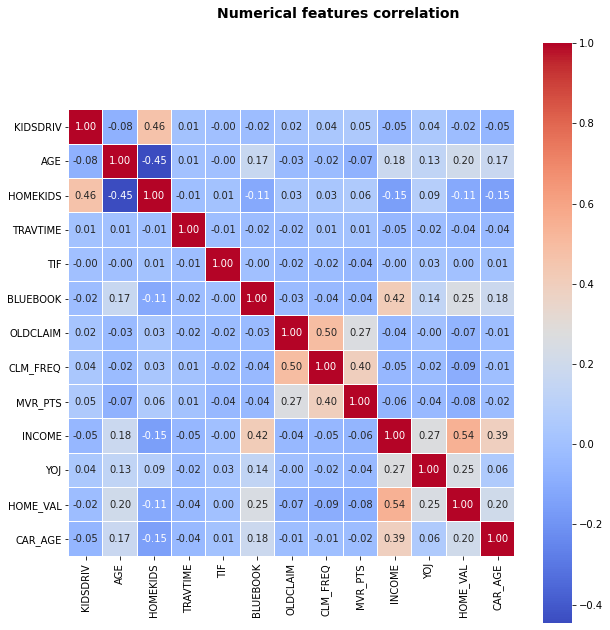

In [467]:
fig, (ax) = plt.subplots(1, 1, figsize=(10,10))

corr = training_data[num_var].corr()

hm = sns.heatmap(corr, 
                 ax=ax,
                 cmap="coolwarm", 
                 square=True,    
                 annot=True, 
                 fmt='.2f',
                 linewidths=.05)

fig.subplots_adjust(top=0.93)
fig.suptitle('Numerical features correlation',fontsize=14, fontweight='bold')
plt.show()

$HOMEKIDS$ et $KIDSDRIV$ étant fortement corrélées, on décide de les supprimer pour créer une nouvelle colonne $HOME\_KIDS\_DRIVING$ représentant le nombre d'enfants pouvant conduire si $KIDSDRIV$ et $HOMEKIDS$ sont différents de 0

In [468]:
training_data['HOME_KIDS_DRIVING'] = np.where((training_data["HOMEKIDS"] != 0) & (training_data["KIDSDRIV"] != 0), training_data["KIDSDRIV"], 0)
test_data['HOME_KIDS_DRIVING'] = np.where((test_data["HOMEKIDS"] != 0) & (test_data["KIDSDRIV"] != 0), test_data["KIDSDRIV"], 0)
Col_to_drop = ["HOMEKIDS","KIDSDRIV"]
training_data =training_data.drop(Col_to_drop, axis=1)
test_data =test_data.drop(Col_to_drop, axis=1)

$OLDCLAIMS$ et $CLM\_FREQ$ étant fortement corrélées, on décide de les supprimer pour créer une nouvelle colonne $MEAN\_OLD\_CLAIMS$ représentant en moyenne le coût engendré par réclamation du client si $CLM\_FREQ$ le nombre de réclamations précédemment faites est différent de 0

In [469]:
training_data["MEAN_OLD_CLAIMS"] = np.where((training_data["CLM_FREQ"] != 0), training_data["OLDCLAIM"] / training_data["CLM_FREQ"], 0)
test_data["MEAN_OLD_CLAIMS"] = np.where((test_data["CLM_FREQ"] != 0), test_data["OLDCLAIM"] / test_data["CLM_FREQ"], 0)
Col_to_drop = ["CLM_FREQ", "OLDCLAIM"]
training_data =training_data.drop(Col_to_drop, axis=1)
test_data =test_data.drop(Col_to_drop, axis=1)

Ainsi on redéfinit nos variables pour le modèle et on vérifit que les variables numériques sont moins corrélées entre elles

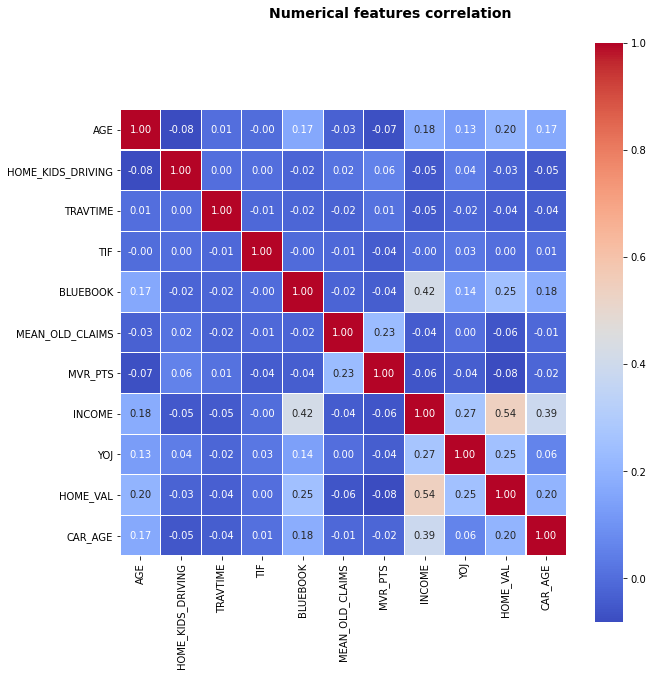

In [470]:
num_var = ['AGE', 'HOME_KIDS_DRIVING',
          'TRAVTIME','TIF', "BLUEBOOK","MEAN_OLD_CLAIMS",
          'MVR_PTS', "INCOME","YOJ","HOME_VAL",
          "CAR_AGE"]

cat_var = ['PARENT1', 'MSTATUS', 'SEX', 'EDUCATION',
          'CAR_USE','CAR_TYPE','RED_CAR','REVOKED',
          'URBANICITY',"JOB"]

target = ['TARGET_FLAG']

fig, (ax) = plt.subplots(1, 1, figsize=(10,10))

corr = training_data[num_var].corr()

hm = sns.heatmap(corr, 
                 ax=ax,
                 cmap="coolwarm", 
                 square=True,    
                 annot=True, 
                 fmt='.2f',
                 linewidths=.05)

fig.subplots_adjust(top=0.93)
fig.suptitle('Numerical features correlation',fontsize=14, fontweight='bold')
plt.show()

#### Corrélations entre nos variables catégoriques et la variable cible

In [471]:
#tableau de contigence

for X in cat_var:
    Y = "TARGET_FLAG"
    cont = pd.pivot_table(training_data[[X, Y]], index=X, columns=Y, aggfunc=len).fillna(0)
    chi2, pvalue, degrees, expected = chi2_contingency(cont)
    print("Chi2 test " + X)
    print(chi2)
    print(format(pvalue, '.4f'))
    print(degrees)
    print()

Chi2 test PARENT1
197.3217319441918
0.0000
1

Chi2 test MSTATUS
146.70171048572888
0.0000
1

Chi2 test SEX
3.515378954640571
0.0608
1

Chi2 test EDUCATION
169.78221355899137
0.0000
4

Chi2 test CAR_USE
166.431629068545
0.0000
1

Chi2 test CAR_TYPE
170.1806007319388
0.0000
5

Chi2 test RED_CAR
0.5401427249124635
0.4624
1

Chi2 test REVOKED
187.056049713027
0.0000
1

Chi2 test URBANICITY
407.39552325873024
0.0000
1

Chi2 test JOB
244.7198151472096
0.0000
7



On décide ainsi de supprimer $RED\_CAR$ pour laquelle la p-value montre que le résultat n'est pas significatif 

In [472]:
Col_to_drop = ["RED_CAR"]
training_data =training_data.drop(Col_to_drop, axis=1)
test_data =test_data.drop(Col_to_drop, axis=1)

num_var = ['AGE', 'HOME_KIDS_DRIVING',
          'TRAVTIME','TIF', "BLUEBOOK","MEAN_OLD_CLAIMS",
          'MVR_PTS', "INCOME","YOJ","HOME_VAL",
          "CAR_AGE"]

cat_var = ['PARENT1', 'MSTATUS', 'SEX', 'EDUCATION',
          'CAR_USE','CAR_TYPE','REVOKED',
          'URBANICITY',"JOB"]

target = ['TARGET_FLAG']

### Séparation des données en training set et test set

In [473]:
X = training_data.drop("TARGET_FLAG", axis=1)
y = training_data["TARGET_FLAG"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

### Traitement de données
On crée les différentes étapes de transformations à appliquer aux données numériques (normalisation) et catégoriques (encodage)

In [474]:
numeric_transformer = Pipeline(steps=[("imputer",SimpleImputer(strategy="constant", fill_value=0)),("scaler", MaxAbsScaler())])
categorical_transformer = Pipeline(steps=[
                                    ("imputer", SimpleImputer(strategy="constant", fill_value="NA")),
                                    ("onehot", OneHotEncoder(handle_unknown='ignore'))])
preproc = ColumnTransformer(transformers=[("num", numeric_transformer, num_var),
                                          ("cat", categorical_transformer, cat_var)])

### Imbalanced dataset

On voit assez vite que notre training set n'est pas bien équilibré en termes de représentation des différentes modalités de la variable cible. N'ayant qu'à peu près 6000 observations dans le dataset, on décide d'oversample nos données. C'est-à-dire de générer de nouvelles observations pour que les deux modalités soit aussi bien représentées

In [475]:
train = pd.concat([X_train, y_train], axis=1)
train1 = train.loc[train['TARGET_FLAG'] == 1].reset_index(drop=True)
train0 = train.loc[train['TARGET_FLAG'] == 0].reset_index(drop=True)
print(train1.shape[0])
print(train0.shape[0])
#N = train1.shape[0]

1592
4524


In [476]:
oversample = RandomOverSampler()
X_train, y_train = oversample.fit_resample(X_train,y_train)

train = pd.concat([X_train, y_train], axis=1)
train1 = train.loc[train['TARGET_FLAG'] == 1].reset_index(drop=True)
train0 = train.loc[train['TARGET_FLAG'] == 0].reset_index(drop=True)
print(train1.shape[0])
print(train0.shape[0])

4524
4524


### Choix du modèle et de ses paramètres par cross-validation
On décide de comparer 4 modèles de classification que sont le k-NN, la regression logistique, le random forest et le SV Classifier.

In [477]:
models = [('knn', KNeighborsClassifier()),
        ("logreg", LogisticRegression(max_iter=10000, random_state=1)),
         ("RF", RandomForestClassifier(n_estimators=100, max_depth=10, random_state=1)),
         ("svc", LinearSVC(max_iter=5000))]

grids = {"knn" : {'knn__n_neighbors': [1, 2, 3, 4, 5, 7, 10]},
        "logreg" : {'logreg__C': np.logspace(-2, 2, 5, base=2)
                    }, 
         "RF" : {'RF__n_estimators' : np.arange(60,120+1,30),
                 'RF__max_depth': np.arange(7, 13)
                },
         "svc" : {'svc__C': np.logspace(-2, 2, 5, base=2)}
        }

for name, model in models:
    pipe = Pipeline(steps=[('preprocessor', preproc), (name, model)])
    clf = GridSearchCV(pipe, grids[name], cv=3)
    clf.fit(X_train, y_train)
    print('Returned hyperparameter: {}'.format(clf.best_params_))
    print('Best classification accuracy in train is: {}'.format(clf.best_score_))
    print('Classification accuracy on test is: {}'.format(clf.score(X_test, y_test)))
    print()
    

Returned hyperparameter: {'knn__n_neighbors': 1}
Best classification accuracy in train is: 0.8671529619805481
Classification accuracy on test is: 0.7072094163805788

Returned hyperparameter: {'logreg__C': 0.25}
Best classification accuracy in train is: 0.7361847922192749
Classification accuracy on test is: 0.7140755272192251

Returned hyperparameter: {'RF__max_depth': 12, 'RF__n_estimators': 90}
Best classification accuracy in train is: 0.8682581786030061
Classification accuracy on test is: 0.7435017165277097

Returned hyperparameter: {'svc__C': 0.25}
Best classification accuracy in train is: 0.733974358974359
Classification accuracy on test is: 0.7091711623344776



Au vu des résultats précédents, le meilleur modèle est le random forest avec 90 arbres et une profondeur max de 12. Nous allons analyser plus en profondeur tous nos résultats en détail.

In [478]:
def confusion_metrics (conf_matrix):
# save confusion matrix and slice into four pieces
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    
    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    # calculate mis-classification
    conf_misclassification = 1 - conf_accuracy
    
    # calculate the sensitivity (recall)
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    
    # calculate precision
    conf_precision = (TP / float(TP + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    print('-'*30)
    print(f'Accuracy: {round(conf_accuracy,2)}') 
    print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    print(f'Sensitivity (Recall): {round(conf_sensitivity,2)}') 
    print(f'Specificity: {round(conf_specificity,2)}') 
    print(f'Precision: {round(conf_precision,2)}')
    print(f'f_1 Score: {round(conf_f1,2)}')

### k-NN results

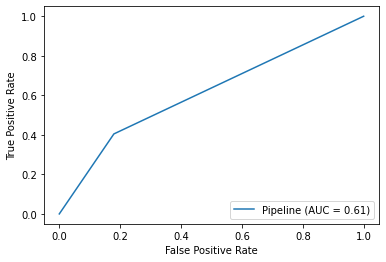

In [479]:
best_KNN = KNeighborsClassifier(n_neighbors=1)
pipe = Pipeline(steps=[('preprocessor', preproc), ('KNN', best_KNN)])
best_pipe = pipe.fit(X_train, y_train)
ROC = plot_roc_curve(best_pipe, X_test, y_test)
plt.show()

Balanced Accuracy: 0.6126550546481223


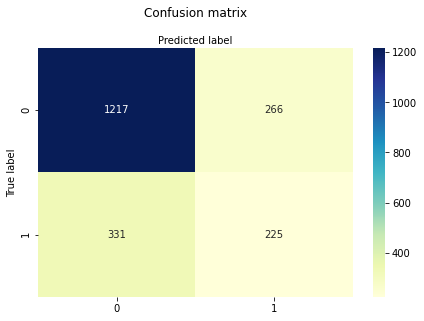

In [480]:
print("Balanced Accuracy:",balanced_accuracy_score(y_test,best_pipe.predict(X_test)))
cnf_matrix = confusion_matrix(y_test, best_pipe.predict(X_test))
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g') # create heatmap
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [481]:
confusion_metrics(cnf_matrix)

True Positives: 225
True Negatives: 1217
False Positives: 266
False Negatives: 331
------------------------------
Accuracy: 0.71
Mis-Classification: 0.29
Sensitivity (Recall): 0.4
Specificity: 0.82
Precision: 0.46
f_1 Score: 0.43


### Logistic Regression results

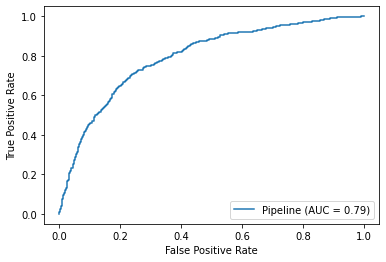

In [482]:
best_logreg = LogisticRegression(max_iter=10000, C=1.0, random_state=1)
pipe = Pipeline(steps=[('preprocessor', preproc), ('LogisticRegression', best_logreg)])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
ROC = plot_roc_curve(pipe, X_test, y_test)
plt.show()

Balanced Accuracy: 0.7247413128162339


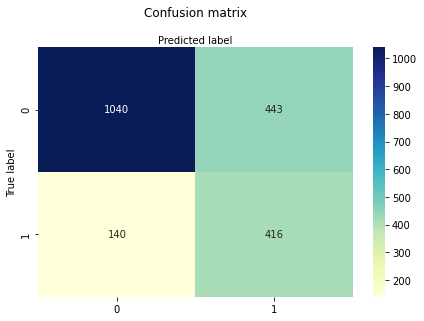

In [483]:
print("Balanced Accuracy:",balanced_accuracy_score(y_test,y_pred))
cnf_matrix = confusion_matrix(y_test, y_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g') # create heatmap
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [484]:
confusion_metrics(cnf_matrix)

True Positives: 416
True Negatives: 1040
False Positives: 443
False Negatives: 140
------------------------------
Accuracy: 0.71
Mis-Classification: 0.29
Sensitivity (Recall): 0.75
Specificity: 0.7
Precision: 0.48
f_1 Score: 0.59


Au vu des précédents résultats, on voit déjà que la régression logistique est plus adaptée que le k-NN

### SVC results

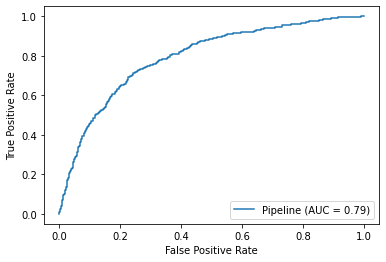

In [485]:
best_SVC = LinearSVC(max_iter=5000,C=0.5)
pipe = Pipeline(steps=[('preprocessor', preproc), ('SVC', best_SVC)])
best_pipe = pipe.fit(X_train, y_train)
ROC = plot_roc_curve(best_pipe, X_test, y_test)
plt.show()

Balanced Accuracy: 0.7237304559589011


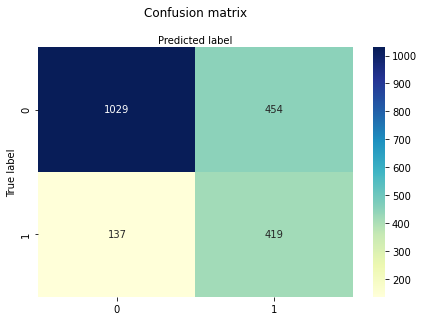

In [486]:
print("Balanced Accuracy:",balanced_accuracy_score(y_test,best_pipe.predict(X_test)))
cnf_matrix = confusion_matrix(y_test, best_pipe.predict(X_test))
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g') # create heatmap
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [487]:
confusion_metrics(cnf_matrix)

True Positives: 419
True Negatives: 1029
False Positives: 454
False Negatives: 137
------------------------------
Accuracy: 0.71
Mis-Classification: 0.29
Sensitivity (Recall): 0.75
Specificity: 0.69
Precision: 0.48
f_1 Score: 0.59


Logiquement, les résultats entre le SVC et la régression logistique sont les mêmes puisque c'est linéaire

### Random Forest results

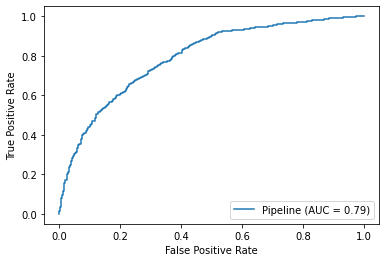

In [488]:
best_RF = RandomForestClassifier(n_estimators=90, max_depth=12, random_state=1)
pipe = Pipeline(steps=[('preprocessor', preproc), ('RandomForest', best_RF)])
best_pipe = pipe.fit(X_train, y_train)
ROC = plot_roc_curve(best_pipe, X_test, y_test)
plt.show()

Balanced Accuracy: 0.7033732420671689


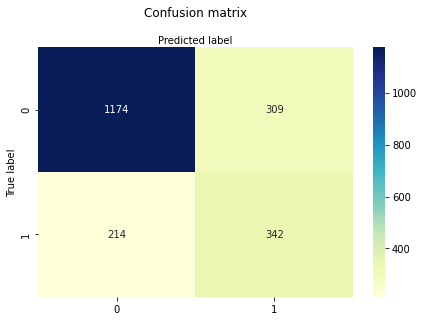

In [489]:
print("Balanced Accuracy:",balanced_accuracy_score(y_test,best_pipe.predict(X_test)))
cnf_matrix = confusion_matrix(y_test, best_pipe.predict(X_test))
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g') # create heatmap
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [490]:
confusion_metrics(cnf_matrix)

True Positives: 342
True Negatives: 1174
False Positives: 309
False Negatives: 214
------------------------------
Accuracy: 0.74
Mis-Classification: 0.26
Sensitivity (Recall): 0.62
Specificity: 0.79
Precision: 0.53
f_1 Score: 0.57


Les résultats du Random Forest outperforment le meilleur des 3 modèles précédents. En effet, l'accuracy est de 74% au lieu de 71%, l'erreur de misclassification est de 26% au lieu de 29%, la spécificité est de 79% au lieu de 70%, la précision est de 53% au lieu de 48%. Seuls le F1-score et le rappel sont meilleurs pour l'autre modèle avec pour le random forest 57% au lieu de 59% comme F1-score et 62% au lieu de 75% pour le rappel.

### Importance de chacune des variables dans le modèle en prenant le Random Forest

In [491]:
num_check = []
cat_check = []
all_type_var = []

for col in X_train.columns.tolist():
    if is_numeric_dtype(X_train[col]) == True:
        num_check.append(col)
        all_type_var.append(col)
    elif is_categorical_dtype(X_train[col]) == True:
        cat_feature_names = pd.get_dummies(X_train[col]).columns.tolist()
        new_cat_feature_names = [col + "_" + str(x) for x in cat_feature_names]
        cat_check.extend(new_cat_feature_names)
        all_type_var.extend(new_cat_feature_names)


In [492]:
X_train_preproc = pd.DataFrame(preproc.fit_transform(X_train))
assert len(num_check) + len(cat_check) == len(X_train_preproc.columns.tolist())
dict(list(enumerate(all_type_var)))

{0: 'AGE',
 1: 'YOJ',
 2: 'INCOME',
 3: 'PARENT1_No',
 4: 'PARENT1_Yes',
 5: 'HOME_VAL',
 6: 'MSTATUS_Yes',
 7: 'MSTATUS_z_No',
 8: 'SEX_M',
 9: 'SEX_z_F',
 10: 'EDUCATION_<High School',
 11: 'EDUCATION_Bachelors',
 12: 'EDUCATION_Masters',
 13: 'EDUCATION_PhD',
 14: 'EDUCATION_z_High School',
 15: 'JOB_Clerical',
 16: 'JOB_Doctor',
 17: 'JOB_Home Maker',
 18: 'JOB_Lawyer',
 19: 'JOB_Manager',
 20: 'JOB_Professional',
 21: 'JOB_Student',
 22: 'JOB_z_Blue Collar',
 23: 'TRAVTIME',
 24: 'CAR_USE_Commercial',
 25: 'CAR_USE_Private',
 26: 'BLUEBOOK',
 27: 'TIF',
 28: 'CAR_TYPE_Minivan',
 29: 'CAR_TYPE_Panel Truck',
 30: 'CAR_TYPE_Pickup',
 31: 'CAR_TYPE_Sports Car',
 32: 'CAR_TYPE_Van',
 33: 'CAR_TYPE_z_SUV',
 34: 'REVOKED_No',
 35: 'REVOKED_Yes',
 36: 'MVR_PTS',
 37: 'CAR_AGE',
 38: 'URBANICITY_Highly Urban/ Urban',
 39: 'URBANICITY_z_Highly Rural/ Rural',
 40: 'HOME_KIDS_DRIVING',
 41: 'MEAN_OLD_CLAIMS'}

In [493]:
importances = pipe.named_steps["RandomForest"].feature_importances_
data = {'Variables':all_type_var, 'Importances':importances} 
feature_importances = pd.DataFrame(data).sort_values(by ='Importances', ascending=False)
feature_importances.head()

,Variables,Importances
7,MSTATUS_z_No,0.086643
5,HOME_VAL,0.078182
9,SEX_z_F,0.072143
4,PARENT1_Yes,0.066572
2,INCOME,0.060814


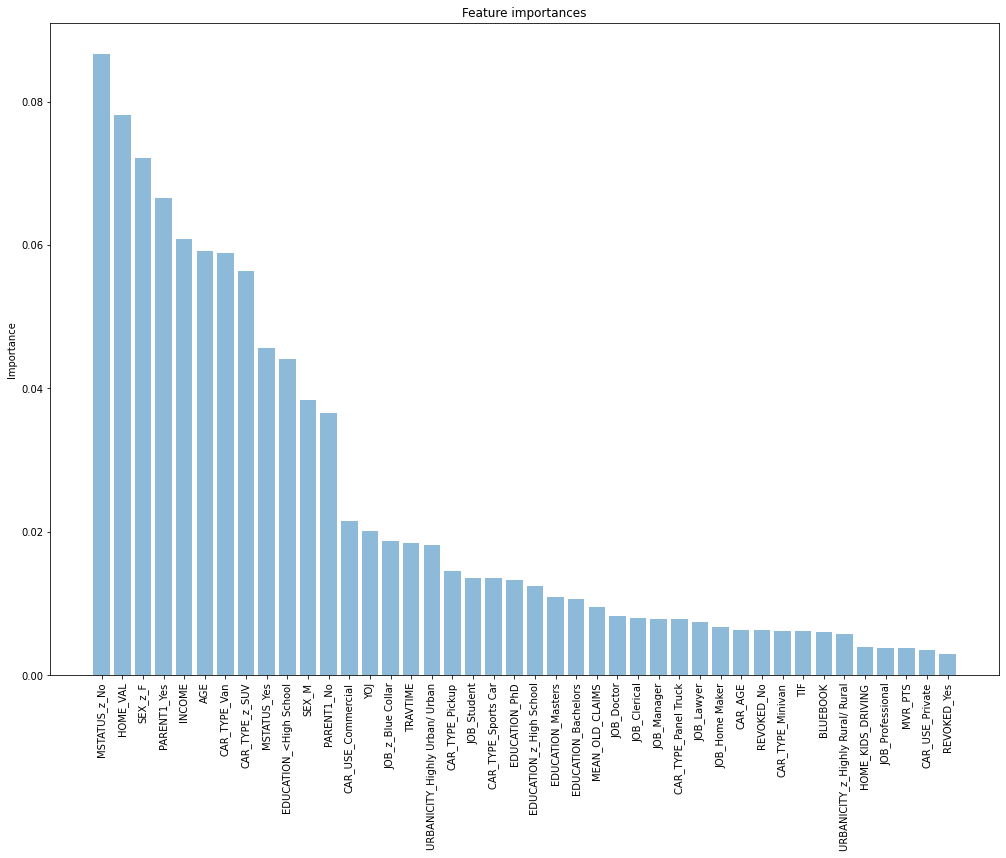

In [494]:
f = plt.figure(figsize=(17,12))
y_pos = np.arange(len(feature_importances['Variables']))
plt.bar(y_pos, feature_importances['Importances'], align='center', alpha=0.5)
plt.xticks(y_pos, feature_importances['Variables'], rotation='vertical')
plt.ylabel('Importance')
plt.title('Feature importances')
plt.show()